In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

SEED = 28
np.random.seed(SEED)
torch.manual_seed(SEED)

device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
# train/val
train_data = pd.read_csv('ttids21/train.csv')
zipcode_data = pd.read_csv('ttids21/zipcodes.csv')
zipcode_data.drop_duplicates(subset=['zipcode'], keep='first', inplace=True)

X = train_data.drop(columns=['Unnamed: 0', 'price'])
y = train_data.price

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.7, random_state=SEED)

def f(x):
    if x < 20:
        return 2000 + x
    if x < 100:
        return 1900 + x
    return x

train_X.registration_year = train_X.registration_year.map(f)
val_X.registration_year = val_X.registration_year.map(f)

train_X = pd.merge(train_X, zipcode_data, left_on='zipcode', right_on='zipcode', how="left")
val_X = pd.merge(val_X, zipcode_data, left_on='zipcode', right_on='zipcode', how="left")

my_imputer = SimpleImputer(strategy='most_frequent')

imputed_train_X = pd.DataFrame(my_imputer.fit_transform(train_X))
imputed_val_X = pd.DataFrame(my_imputer.transform(val_X))

imputed_train_X.columns = train_X.columns
imputed_val_X.columns = val_X.columns

clustering_data = imputed_train_X[['latitude', 'longitude']]
cluster_picker = KMeans(n_clusters=200)
clusters = cluster_picker.fit_predict(clustering_data)
imputed_train_X['geo_cluster'] = clusters
clustering_data = imputed_val_X[['latitude', 'longitude']]
imputed_val_X['geo_cluster'] = cluster_picker.predict(clustering_data)

imputed_train_X.drop(columns=['Unnamed: 0', 'zipcode', 'city', 'latitude', 'longitude'])
imputed_val_X.drop(columns=['Unnamed: 0', 'zipcode', 'city', 'latitude', 'longitude'])

le = LabelEncoder()

columns_to_transform = ['type', 'model', 'fuel', 'brand']

d = dict()
label_encoders = dict()

for col in columns_to_transform:
    le = LabelEncoder()
    le = le.fit(np.append(imputed_train_X[col], ['-1']))
    label_encoders[col] = le
    imputed_train_X[col] = le.transform(imputed_train_X[col])
    classes = le.classes_
    d[col] = len(le.classes_)
    unknown_classes = set(imputed_val_X[col]) - set(classes)
    imputed_val_X[col].replace(unknown_classes, '-1', inplace=True)
    imputed_val_X[col] = le.transform(imputed_val_X[col])

imputed_train_X.replace(['manual', 'auto'], [0, 1], inplace=True)
imputed_val_X.replace(['manual', 'auto'], [0, 1], inplace=True)

columns_to_remove = ['zipcode', 'Unnamed: 0', 'city', 'latitude', 'longitude']

imputed_train_X.drop(columns=columns_to_remove, inplace=True)
imputed_val_X.drop(columns=columns_to_remove, inplace=True)

# test
test_data = pd.read_csv('ttids21/test_no_target.csv')

test_data.index = test_data['Unnamed: 0']
indexes = test_data.index

test_data.drop(columns=['Unnamed: 0'], inplace=True)

test_data.registration_year = test_data.registration_year.map(f)

test_data = pd.merge(test_data, zipcode_data, left_on='zipcode', right_on='zipcode', how="left")
test_data.index = indexes

imputed_test = pd.DataFrame(my_imputer.transform(test_data))
imputed_test.columns = test_data.columns
imputed_test.index = indexes

clustering_data = imputed_test[['latitude', 'longitude']]
imputed_test['geo_cluster'] = cluster_picker.predict(clustering_data)
imputed_test.drop(columns=['Unnamed: 0', 'zipcode', 'city', 'latitude', 'longitude'])

for col in columns_to_transform:
    le = label_encoders[col]
    classes = le.classes_
    unknown_classes = set(imputed_test[col]) - set(classes)
    imputed_test[col].replace(unknown_classes, '-1', inplace=True)
    imputed_test[col] = le.transform(imputed_test[col])

imputed_test.replace(['manual', 'auto'], [0, 1], inplace=True)
imputed_test.drop(columns=columns_to_remove, inplace=True)

D:\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [7]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.n_samples = x.shape[0]
    
    def __getitem__(self, index):
        return self.x.iloc[index].values, self.y.iloc[index]
    
    def __len__(self):
        return self.n_samples
    
class TestDataset(Dataset):
    def __init__(self, x):
        self.x = x
        self.n_samples = x.shape[0]
    
    def __getitem__(self, index):
        return self.x.iloc[index].values
    
    def __len__(self):
        return self.n_samples

# n_types = imputed_train_X.type.unique()
# n_models = imputed_train_X.model.unique()
# n_fuels = imputed_train_X.fuel.unique()
# n_brands = imputed_train_X.type.unique()
n_geo_points = cluster_picker.n_clusters

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform(m.weight)
        m.bias.data.fill_(0.01)

size1 = 128
size2 = 1024
size3 = 6*size1 + size2
size4 = 2048

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.binary_branch = nn.Sequential(
            nn.Linear(2, size1),
            nn.BatchNorm1d(num_features=size1),
            # nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(size1, size1),
            nn.BatchNorm1d(num_features=size1),
            # nn.Dropout(p=0.3),
            nn.ReLU(),
        )
        self.features_branch = nn.Sequential(
            nn.Linear(5, size2),
            nn.BatchNorm1d(num_features=size2),
            # nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(size2, size2),
            nn.BatchNorm1d(num_features=size2),
            # nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(size2, size2),
            nn.BatchNorm1d(num_features=size2),
            # nn.Dropout(p=0.3),
            nn.ReLU(),
        )
        self.type_branch = nn.Sequential(
            nn.Embedding(d['type'], size1),
            nn.ReLU(),
            nn.Linear(size1, size1),
            # nn.Dropout(p=0.3),
            nn.ReLU(),
        )
        self.model_branch = nn.Sequential(
            nn.Embedding(d['model'], size1),
            nn.ReLU(),
            nn.Linear(size1, size1),
            # nn.Dropout(p=0.3),
            nn.ReLU(),
        )
        self.fuel_branch = nn.Sequential(
            nn.Embedding(d['fuel'], size1),
            nn.ReLU(),
            nn.Linear(size1, size1),
            # nn.Dropout(p=0.3),
            nn.ReLU(),
        )
        self.brand_branch = nn.Sequential(
            nn.Embedding(d['brand'], size1),
            nn.ReLU(),
            nn.Linear(size1, size1),
            # nn.Dropout(p=0.3),
            nn.ReLU(),
        )
        self.geo_branch = nn.Sequential(
            nn.Embedding(n_geo_points, size1),
            nn.ReLU(),
            nn.Linear(size1, size1),
            # nn.Dropout(p=0.3),
            nn.ReLU()
        )
        self.main_branch = nn.Sequential(
            nn.Linear(size3, size4),
            nn.BatchNorm1d(num_features=size4),
            # nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(size4, size4),
            nn.BatchNorm1d(num_features=size4),
            # nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(size4, size4),
            nn.BatchNorm1d(num_features=size4),
            # nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(size4, 1)
        )
        
        self.binary_branch.apply(init_weights)
        self.features_branch.apply(init_weights)
        self.type_branch.apply(init_weights)
        self.model_branch.apply(init_weights)
        self.fuel_branch.apply(init_weights)
        self.brand_branch.apply(init_weights)
        self.geo_branch.apply(init_weights)
        self.main_branch.apply(init_weights)
        
    def forward(self, x):
        out1 = self.binary_branch(x[:, [3, 9]].to(torch.float32))
        out2 = self.features_branch(x[:, [0, 2, 4, 6, 10]].to(torch.float32))
        out3 = self.type_branch(x[:, 1].to(torch.long))
        out4 = self.model_branch(x[:, 5].to(torch.long))
        out5 = self.fuel_branch(x[:, 7].to(torch.long))
        out6 = self.brand_branch(x[:, 8].to(torch.long))
        out7 = self.geo_branch(x[:, 11].to(torch.long))
        out = torch.cat((out1, out2, out3, out4, out5, out6, out7), 1)
        out = self.main_branch(out)
        return out
    

def mean_absolute_percentage_error(y_pred, y_true):
    return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100


model = NeuralNetwork().to(device)

batch_size = 64
train_dataset = CustomDataset(imputed_train_X, train_y)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = CustomDataset(imputed_val_X, val_y)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

print(len(train_dataloader))
n_epochs = 100
train_epoch_loss = np.zeros(n_epochs, dtype=np.float32)
val_epoch_loss = np.zeros(n_epochs, dtype=np.float32)
criterion = mean_absolute_percentage_error
# optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, nesterov=True, weight_decay= 0.0001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.000001)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.05, mode='exp_range', gamma=0.99994, step_size_up=len(train_dataloader)*2)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr_max, steps_per_epoch=len(train_dataloader), epochs=n_epochs)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# actual_lr = lr_max
# low_lr = True

def train(dataloader, model, loss_fn, optimizer):
    n_iterations = len(dataloader)
    model.train()
    train_loss = 0
    y_pred = torch.tensor([]).to(device)
    y_true = torch.tensor([]).to(device)
    for i, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        y = y.reshape(y.shape[0], 1).type(torch.float32)

        pred = model(x)
        pred = pred.to(device)
        loss = loss_fn(pred, y)
        
        y_pred = torch.cat((y_pred, pred))
        y_true = torch.cat((y_true, y))
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()
        
        if (i+1) % 100 == 0:
            print(f'Step {i+1} / {n_iterations}, loss = {loss.item():.4f}')
    
    train_loss = loss_fn(y_pred, y_true)
    print(f'Train loss: {train_loss:>8f}')
    return train_loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    y_pred = torch.tensor([]).to(device)
    y_true = torch.tensor([]).to(device)
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            y = y.reshape(y.shape[0], 1).to(torch.float32)
            
            pred = model(x)
            pred = pred.to(device)
            y_pred = torch.cat((y_pred, pred))
            y_true = torch.cat((y_true, y))

    # y_pred = torch.tensor(y_pred).to(device)
    # y_true = torch.tensor(y_true).to(device)
    test_loss = loss_fn(y_pred, y_true)
    print(f'Validation loss: {test_loss:>8f} \n')
    return test_loss

def save_checkpoint(state, filename):
    print("Saving checkpoint...")
    torch.save(state, filename)

def load_checkpoint(checkpoint):
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

547


C:\Users\17F2~1\AppData\Local\Temp/ipykernel_1996/1742191283.py:32: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(m.weight)


In [7]:
learning_rates = [1e-6]
while learning_rates[-1] < 1:
    learning_rates.append(learning_rates[-1] * 2)

In [8]:
learning_rates

[1e-06,
 2e-06,
 4e-06,
 8e-06,
 1.6e-05,
 3.2e-05,
 6.4e-05,
 0.000128,
 0.000256,
 0.000512,
 0.001024,
 0.002048,
 0.004096,
 0.008192,
 0.016384,
 0.032768,
 0.065536,
 0.131072,
 0.262144,
 0.524288,
 1.048576]

In [9]:
lr_max

NameError: name 'lr_max' is not defined

In [8]:
for epoch in range(n_epochs):
    # if epoch % 3 == 0:
    #     if low_lr:
    #         actual_lr *= 0.8
    #         optimizer.param_groups[0]['lr'] = actual_lr
    #     else:
    #         optimizer.param_groups[0]['lr'] = lr_min
    #     low_lr = not low_lr
    
    print(f"lr: {optimizer.param_groups[0]['lr']}")
    print(f'Epoch {epoch+1}\n--------------------------')
    loss = train(train_dataloader, model, criterion, optimizer)
    train_epoch_loss[epoch] = loss
    loss = test(valid_dataloader, model, criterion)
    val_epoch_loss[epoch] = loss
    scheduler.step(loss)
    # scheduler.step()
    checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
    save_checkpoint(checkpoint, f'{epoch}.pth.tar')
    
print("Done!")

lr: 0.001
Epoch 1
--------------------------
Step 100 / 547, loss = 90.1300
Step 200 / 547, loss = 75.7449
Step 300 / 547, loss = 72.8898
Step 400 / 547, loss = 69.2665
Step 500 / 547, loss = 61.2713
Train loss: 75.891205
Validation loss: 66.432190 

Saving checkpoint...
lr: 0.001
Epoch 2
--------------------------
Step 100 / 547, loss = 54.4435
Step 200 / 547, loss = 52.7624
Step 300 / 547, loss = 48.8156
Step 400 / 547, loss = 52.4656
Step 500 / 547, loss = 55.3066
Train loss: 54.321598
Validation loss: 65.044556 

Saving checkpoint...
lr: 0.001
Epoch 3
--------------------------
Step 100 / 547, loss = 41.0321
Step 200 / 547, loss = 42.6372
Step 300 / 547, loss = 39.2091
Step 400 / 547, loss = 41.4402
Step 500 / 547, loss = 36.8801
Train loss: 43.976395
Validation loss: 41.077545 

Saving checkpoint...
lr: 0.001
Epoch 4
--------------------------
Step 100 / 547, loss = 32.3226
Step 200 / 547, loss = 34.0201
Step 300 / 547, loss = 38.9782
Step 400 / 547, loss = 40.3077
Step 500 / 547,

KeyboardInterrupt: 

In [ ]:
learning_rates = [1e-6]
while learning_rates[-1] < 1:
    learning_rates.append(learning_rates[-1] * 1.5)

In [ ]:
learning_rates

In [68]:
torch.cuda.empty_cache()

In [ ]:
epoch_lr_loss = np.zeros(len(learning_rates))
n_epochs = 3
for (i, lr) in enumerate(learning_rates):
    print(f"lr = {lr}")
    model = NeuralNetwork().to(device)
    criterion = mean_absolute_percentage_error
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    # optimizer.param_groups[0]['lr'] = lr
    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}\n--------------------------')
        loss = train(train_dataloader, model, criterion, optimizer)
        train_epoch_loss[epoch] = loss
        epoch_lr_loss[i] = loss
        # loss = test(valid_dataloader, model, criterion)
        # val_epoch_loss[epoch] = loss
        # checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        # save_checkpoint(checkpoint, f'{epoch}.pth.tar')
    print("Done!")

In [ ]:
learning_rates

In [ ]:
plt.plot(range(1, len(learning_rates) + 1), epoch_lr_loss)

In [ ]:
lr_boundary = np.array(epoch_lr_loss).argmin()

In [ ]:
print(learning_rates[lr_boundary])

In [ ]:
lr_max = learning_rates[lr_boundary] / 3
lr_min = lr_max / 30

In [ ]:
lr_max

In [ ]:
lr_

In [5]:
best_model = val_epoch_loss.argmin()

In [16]:
test_dataset = TestDataset(imputed_test)
test_dataloader = DataLoader(dataset=test_dataset, shuffle=False)
best_model = val_epoch_loss.argmin()
print("Best epoch:", best_model)
load_checkpoint(torch.load(f'{best_model}.pth.tar'))

model.eval()
y_pred = []
with torch.no_grad():
    for x in test_dataloader:
        x = x.to(device)
        pred = model(x)
        y_pred.append(pred.item())

y_pred = pd.DataFrame(data={
    'id': indexes, 
    'Predicted': y_pred}, index=indexes)

pd.DataFrame(y_pred).to_csv('submission.csv',
        columns=['id', 'Predicted'], index=False)

Best epoch: 67


In [ ]:
p

5


In [21]:
import matplotlib.pyplot as plt

In [19]:
cnt = 20

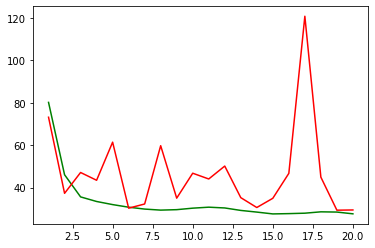

In [22]:
plt.plot(range(1, n_epo + 1), train_epoch_loss[:cnt], 'g', range(1, cnt + 1), val_epoch_loss[:cnt], 'r')

In [6]:
val_epoch_loss[best_model]

27.3481

In [ ]:
rf_clf = RandomForestRegressor(n_estimators=1000)
rf_clf.fit(imputed_train_X, train_y)
y_pred = rf_clf.predict(imputed_val_X)

In [ ]:
mean_absolute_percentage_error(y_pred, torch.tensor(np.array(val_y)))